In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from p5lib.constants import *
from p5lib.parameters import *

vehicle = imread('writeup_resources' + os.sep + 'vehicle.png')
non_vehicle = imread('writeup_resources' + os.sep + 'non-vehicle.png')
image = imread('test_images' + os.sep + 'test4.jpg')

def plot_12(fig1, fig2, size=(8, 8)):
    cmap1 = fig1.setdefault('cmap', 'Paired')
    cmap2 = fig2.setdefault('cmap', 'Paired')

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=size)
    ax1.imshow(fig1['image'], cmap=cmap1)
    ax1.set_title(fig1['title'])
    ax2.imshow(fig2['image'], cmap=cmap2)
    ax2.set_title(fig2['title'])
    plt.show()

def plot_hist(chann1, chann2, chann3, bin_center):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))

    ax1.bar(bin_center, chann1[0])
    ax1.set_title('Channel #1')
    ax2.bar(bin_center, chann2[0])
    ax2.set_title('Channel #2')
    ax3.bar(bin_center, chann3[0])
    ax3.set_title('Channel #3')
    plt.show()

# Vehicle Detection and Tracking Project

## Project overview

The project is divided in two different tasks:

* Model for car detection: model.py
* Sliding window and video processing: P5.py

In model.py a classifier (linear SVM in this case) is built in order to detect cars. Here are some examples of training images:

<table border=0>
    <tr>
    <td>![Vehicle](writeup_resources/image0171.png)</td><td>![Vehicle](writeup_resources/image0185.png)</td><td>![Vehicle](writeup_resources/image0195.png)</td><td>![Vehicle](writeup_resources/image0355.png)</td>
    </tr>
    <tr>
    <td>![Not Vehicle](writeup_resources/extra25.png)</td><td>![Not Vehicle](writeup_resources/image221.png)</td><td>![Not Vehicle](writeup_resources/image229.png)</td><td>![Not Vehicle](writeup_resources/image483.png)</td>
    </tr>
</table>

and this is the relevant code (clutter were removed to increase readability):

```python
# Extract the features for each image group: cars and notcars
car_features = feature_extraction.all_features(cars, color_space=COLOR_SPACE,
                                spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, hist_range=HIST_RANGE,
                                orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, 
                                hog_channel=HOG_CHANNEL,
                                spatial_feat=SPATIAL_FEAT, hist_feat=HIST_FEAT, hog_feat=HOG_FEAT)
notcar_features = feature_extraction.all_features(notcars, color_space=COLOR_SPACE,
                                spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, hist_range=HIST_RANGE,
                                orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, 
                                hog_channel=HOG_CHANNEL,
                                spatial_feat=SPATIAL_FEAT, hist_feat=HIST_FEAT, hog_feat=HOG_FEAT)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

pipeline = Pipeline([
    ('scaling', StandardScaler(with_mean=0, with_std=1)),
    ('classification', SVC(kernel='linear', probability=True))
    ])
pipeline.fit(X, y)
```

Having implemented the classifier, in P5.py the task was to implement a sliding window routine that could scan each video frame and detect where the cars were located. We'll see the sliding windows implementation through the following sectiones

I'll try to discuss every point of the rubric in order to make the reviewing process easily manageable.

## Histogram of Oriented Gradients (HOG) and other features

### HOG

HOG extraction is done in both places: model.py and P5.py. First to extract the features used to train the classifier and then to classify the video frames.

To modularize and reuse the code, this extraction was defined in the library for this project, p5lib, specifically in feature_extraction.py

This is the relevant code:

```python
# Define a function to return HOG features and visualization
def extract_hog(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
        # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
```

The functioning of HOG is to scan the image by cells and compute the gradients of each pixel in that cell. That gradient contribute to a histogram of predefined bins (ORIENT parameter) for that cell, and after that, the cell is normalized within its neighbours cells.

This algorithm extract useful features to be used with any classifier, like SVM (either with a linear kernel or not).

We can visualize the result of this function in a given image:

In [2]:
from p5lib import feature_extraction

hog_vehicle_features, hog_vehicle_image = feature_extraction.extract_hog(cv2.cvtColor(vehicle, cv2.COLOR_RGB2GRAY), ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)
hog_non_vehicle_features, hog_non_vehicle_image = feature_extraction.extract_hog(cv2.cvtColor(non_vehicle, cv2.COLOR_RGB2GRAY), ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)

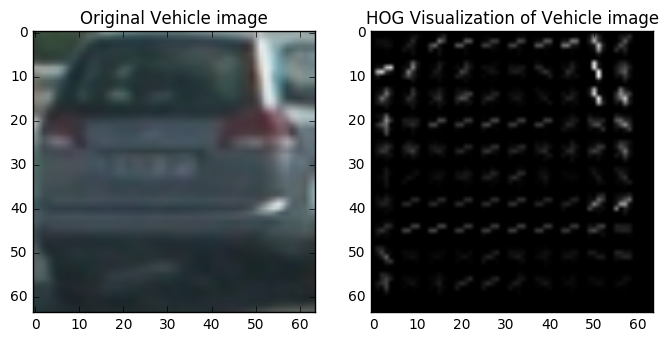

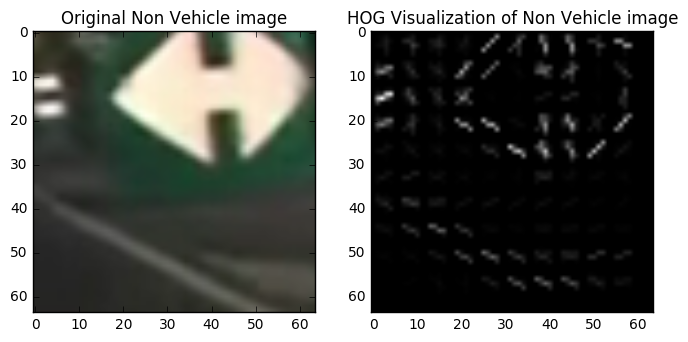

In [3]:
plot_12({'image': vehicle, 'title': 'Original Vehicle image'},
        {'image': hog_vehicle_image, 'title': 'HOG Visualization of Vehicle image', 'cmap': 'gray'})

plot_12({'image': non_vehicle, 'title': 'Original Non Vehicle image'},
        {'image': hog_non_vehicle_image, 'title': 'HOG Visualization of Non Vehicle image', 'cmap': 'gray'})

There's three tunable parameters to detect HOG:

* The number of orientations (ORIENT)
* The number of pixels per cell (PIX_PER_CELL)
* The number of cells per block (CELL_PER_BLOCK)

From those parameters, the one that I've found to have more impact is the quantity of pixels per cell, which in the end create more or less features. Orientations is the numbers of bins, wich does not impact much on the final result, and the number of cells per block is used to normalize the cells. Here's an example of every variation:

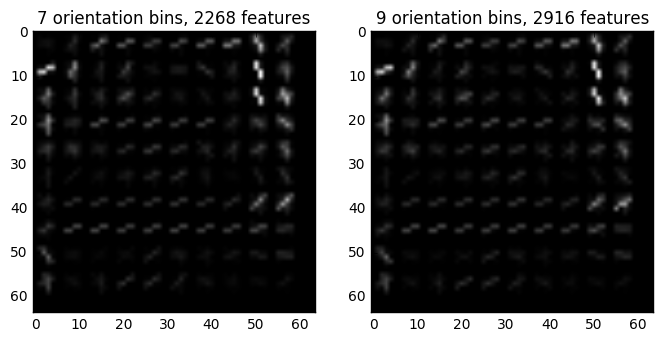

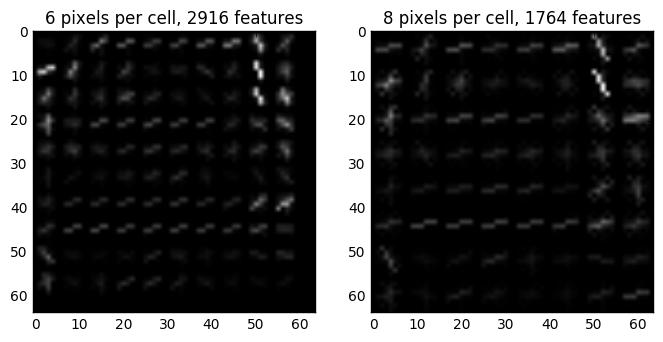

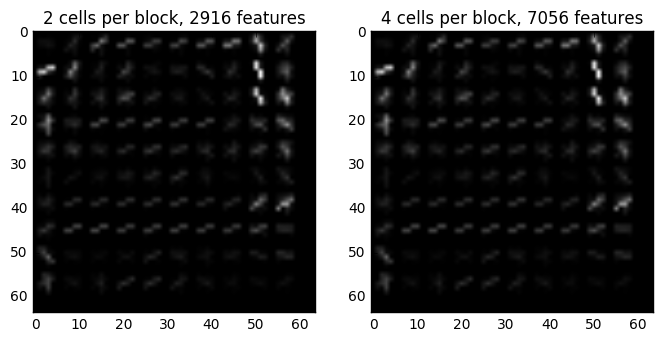

In [4]:
orient_features_7, orient_image_7 = feature_extraction.extract_hog(cv2.cvtColor(vehicle, cv2.COLOR_RGB2GRAY), 7, PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)
orient_features_9, orient_image_9 = feature_extraction.extract_hog(cv2.cvtColor(vehicle, cv2.COLOR_RGB2GRAY), 9, PIX_PER_CELL, CELL_PER_BLOCK, vis=True, feature_vec=True)

plot_12({'image': orient_image_7, 'title': '7 orientation bins, {} features'.format(len(orient_features_7)), 'cmap': 'gray'},
        {'image': orient_image_9, 'title': '9 orientation bins, {} features'.format(len(orient_features_9)), 'cmap': 'gray'})

pix_per_cell_features_6, pix_per_cell_image_6 = feature_extraction.extract_hog(cv2.cvtColor(vehicle, cv2.COLOR_RGB2GRAY), ORIENT, 6, CELL_PER_BLOCK, vis=True, feature_vec=True)
pix_per_cell_features_8, pix_per_cell_image_8 = feature_extraction.extract_hog(cv2.cvtColor(vehicle, cv2.COLOR_RGB2GRAY), ORIENT, 8, CELL_PER_BLOCK, vis=True, feature_vec=True)

plot_12({'image': pix_per_cell_image_6, 'title': '6 pixels per cell, {} features'.format(len(pix_per_cell_features_6)), 'cmap': 'gray'},
        {'image': pix_per_cell_image_8, 'title': '8 pixels per cell, {} features'.format(len(pix_per_cell_features_8)), 'cmap': 'gray'})

cell_per_block_features_2, cell_per_block_image_2 = feature_extraction.extract_hog(cv2.cvtColor(vehicle, cv2.COLOR_RGB2GRAY), ORIENT, PIX_PER_CELL, 2, vis=True, feature_vec=True)
cell_per_block_features_4, cell_per_block_image_4 = feature_extraction.extract_hog(cv2.cvtColor(vehicle, cv2.COLOR_RGB2GRAY), ORIENT, PIX_PER_CELL, 4, vis=True, feature_vec=True)

plot_12({'image': cell_per_block_image_4, 'title': '2 cells per block, {} features'.format(len(cell_per_block_features_2)), 'cmap': 'gray'},
        {'image': cell_per_block_image_4, 'title': '4 cells per block, {} features'.format(len(cell_per_block_features_4)), 'cmap': 'gray'})

### Histogram features

As with HOG, histogram feature extraction is coded in feature_extraction.py

The relevant code is the following:

```python
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256), return_edges=False):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features
```

This functions receives and image and returns the histogram of three channels concatenated. In the project I've used HLS colorspace since it helps to discriminate images better using the H and S channels.

We'll apply this feature extraction to the given images:

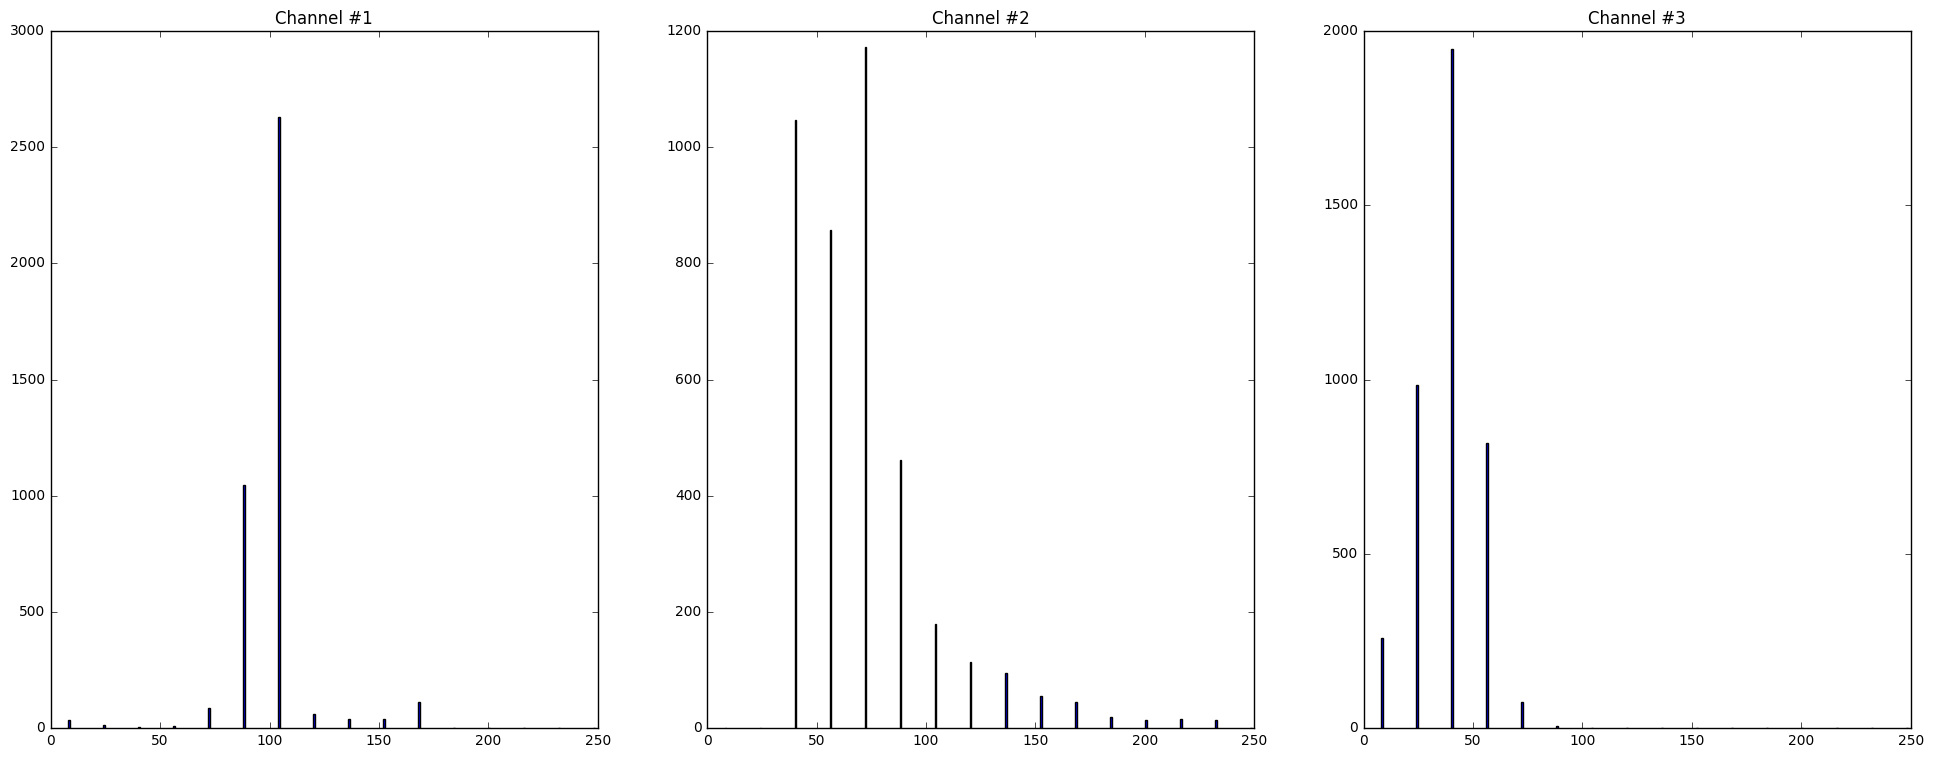

In [5]:
chann1, chann2, chann3, bin_centers, hist_vehicle = feature_extraction.color_hist(cv2.cvtColor(vehicle, cv2.COLOR_RGB2HLS), HIST_BINS, HIST_RANGE)

plot_hist(chann1, chann2, chann3, bin_centers)

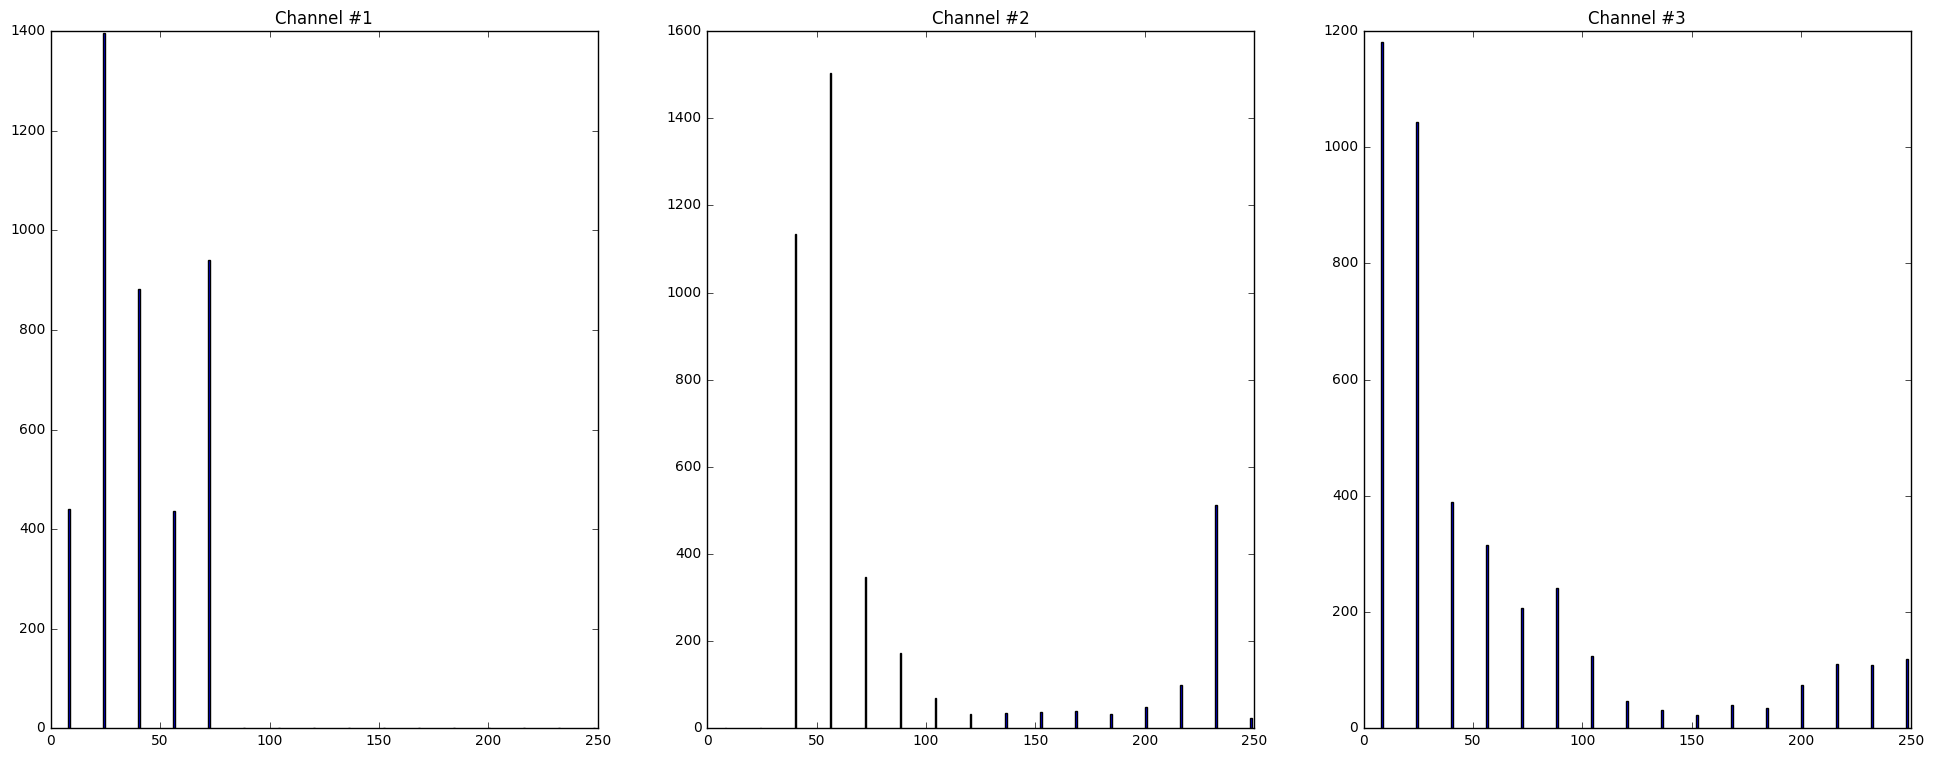

In [6]:
chann1, chann2, chann3, bin_centers, hist_non_vehicle = feature_extraction.color_hist(cv2.cvtColor(non_vehicle, cv2.COLOR_RGB2HLS), HIST_BINS, HIST_RANGE)

plot_hist(chann1, chann2, chann3, bin_centers)

Here we can appreciate that in channel #1 (or channel H), the vehicle image has high values after bin 80 and nov vehicle has high values before bin 75.

In the channel S (or channel #3) we can appreciate that non vehicle image has higher values in bins before 25 (and has lower components up until bin 250) and vehicle image has the data concentrated around bin 25 up to 50.

### Spatial binning

Spatial features take advantage of the raw pixel information from images. But including all the pixels could result in unnecessary and redundant features, thus we have to bin the image and reduce reducing the size but conserving its information.

Spatial binning function is defined in extract_features.py in p5lib library:

```python
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
```

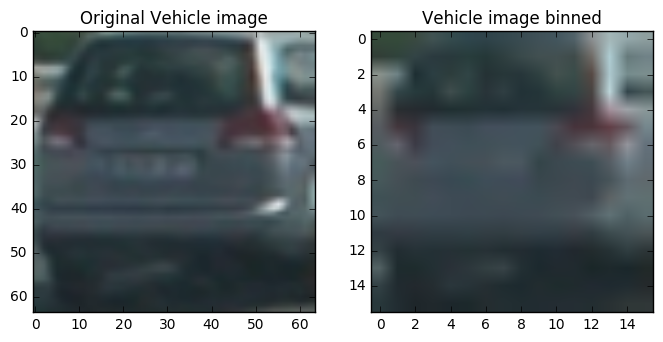

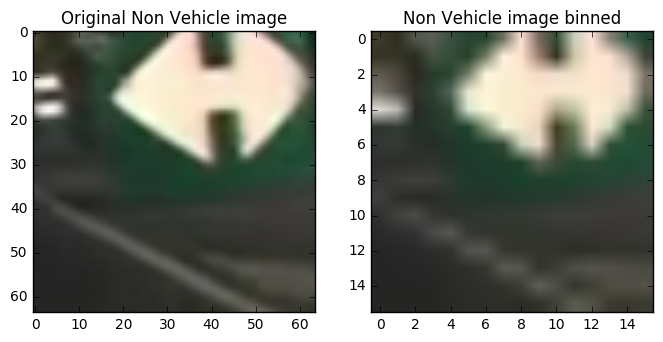

In [7]:
from p5lib.feature_extraction import bin_spatial

image_bins = (16, 16)

spatial_vehicle = bin_spatial(vehicle, image_bins)
spatial_non_vehicle = bin_spatial(non_vehicle, image_bins)

plot_12({'image': vehicle, 'title': 'Original Vehicle image'},
        {'image': np.reshape(spatial_vehicle, image_bins + (3,)), 'title': 'Vehicle image binned'})

plot_12({'image': non_vehicle, 'title': 'Original Non Vehicle image'},
        {'image': np.reshape(spatial_non_vehicle, image_bins + (3,)), 'title': 'Non Vehicle image binned'})

We can appreciate that the information is still preserved (we can differentieate vehicles from non vehicles) but the feature space is much smaller now.

The final combination of parameters used in this project is:

In [8]:
if SPATIAL_FEAT:
    print('SPATIAL_SIZE:', SPATIAL_SIZE)

if HIST_FEAT:
    print('HIST_BINS:', HIST_BINS)
    print('HIST_RANGE:', HIST_RANGE)

if HOG_FEAT:
    print('ORIENT:', ORIENT)
    print('PIX_PER_CELL:', PIX_PER_CELL)
    print('CELL_PER_BLOCK:', CELL_PER_BLOCK)

SPATIAL_SIZE: (16, 16)
HIST_BINS: 16
HIST_RANGE: (0, 256)
ORIENT: 9
PIX_PER_CELL: 6
CELL_PER_BLOCK: 2


Which give us a total of:

In [9]:
all_features = feature_extraction.all_features([vehicle], color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, hog_channel=HOG_CHANNEL, spatial_feat=SPATIAL_FEAT, hist_feat=HIST_FEAT, hog_feat=HOG_FEAT)
print(len(all_features[0]), 'features')

3732 features


## Sliding Window Search

To locate the cars in each frame, a sliding window approach was used over a region of interest. 4 different window sizes were slided over the frame, and then each slide was scaled to 64x64 (the size I've used to train the classifier). Here is the region scanned by the sliding window:

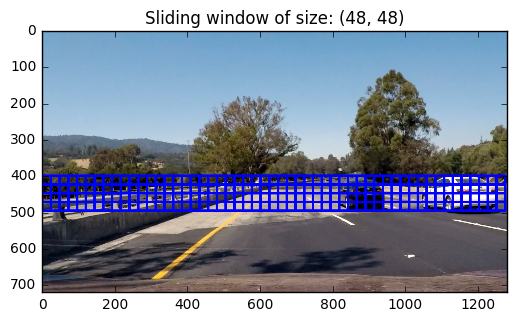

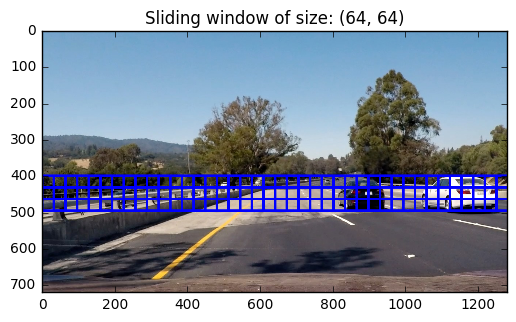

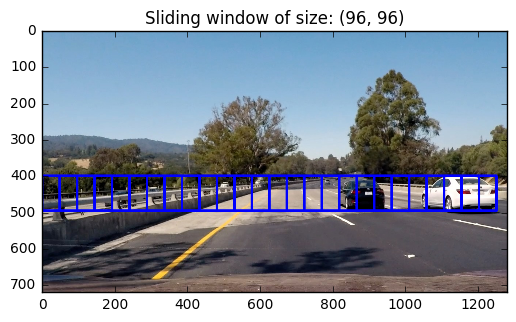

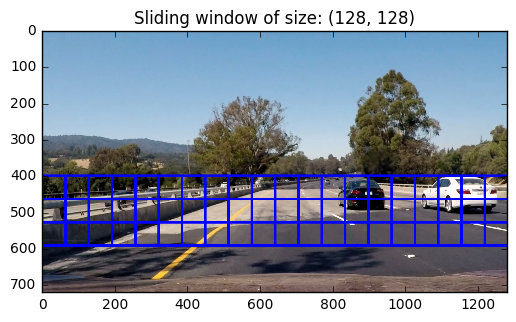

In [10]:
from p5lib import window

pyramid = [((48, 48),  [None, None], [400, 500], (0.5, 0.5)),
           ((64, 64),  [None, None], [400, 500], (0.5, 0.5)),
           ((96, 96),  [None, None], [400, 500], (0.5, 0.5)),
           ((128, 128),[None, None], [400, 600], (0.5, 0.5))]

all_windows = []
for p in pyramid:
    windows = window.slide(image, x_start_stop=p[1], y_start_stop=p[2], xy_window=p[0], xy_overlap=p[3])
    all_windows += windows
    draw = window.draw_boxes(image, windows)
    plt.imshow(draw)
    plt.title('Sliding window of size: {}'.format(p[0]))
    plt.show()

Both the sliding routing and the one to draw boxes are defined in p5lib/windows.py

After extracting each section of the frame, this is passed through the classifier and the result is acumulated in a heatmap only if the probability of being a car is above certain threshold. All this work is done by two functions:

window.search and window.generate_heatmap

Relevant code is here:

```python
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search(img, windows, clf, color_space='RGB', threshold=0.5,
                    spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                    orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                    spatial_feat=True, hist_feat=True, hog_feat=True):


    #1) Create an empty list to append the features for all images
    image_set = []
    features_set = []
    #2) Iterate over all windows in the list and extract features
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        image_set.append(test_img)
    #4) Extract features for all windows
    features = feature_extraction.all_features(image_set, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    #6) Predict using the classifier for all windows
    predictions = clf.predict_proba(features)

    # Create an empty list to receive positive detection windows
    on_windows = []
    windows_prob = []
    # Iterate over all windows and its probabilities
    for prediction, window in zip(predictions, windows):
        #7) If probability is above the threshold, then save the window
        if prediction[1] > threshold:
            on_windows.append(window)
            windows_prob.append(prediction[1])

    #8) Return windows for positive detections
    return on_windows, windows_prob
```

This functions receives a list of windows and return the windows where the classifier detected a car, and the confidence returned by the classifier.

These two outputs are passed to window.generate_heatmap (relevant code here)

```python
# Define a function to return a heatmap given the probabilities
def generate_heatmap(img, bboxes, probs, threshold=0.5):
    heatmap = np.zeros_like(img[:,:,0], dtype='float32')

    for box, prob in zip(bboxes, probs):
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += prob

    # Apply the threshold
    heatmap[heatmap < threshold] = 0

    # Return the heatmap
    return heatmap
```

The heatmap accumulates the confidence of the classifier in the corresponding window generating something like this:

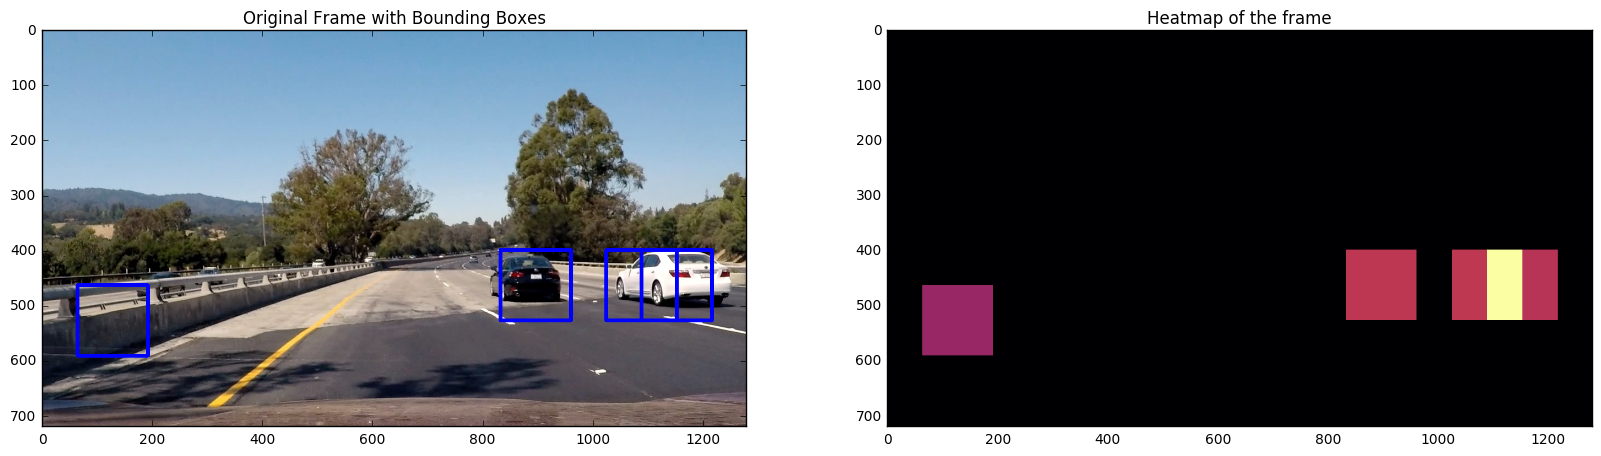

In [11]:
from sklearn.externals import joblib

data = joblib.load('model.pkl')
pipeline = data['model']
config = data['config']

hot_windows, prob_windows = window.search(image, windows, pipeline, color_space=config['COLOR_SPACE'], threshold=PROB_THRESHOLD_DETECTION,
                            spatial_size=config['SPATIAL_SIZE'], hist_bins=config['HIST_BINS'], hist_range=config['HIST_RANGE'],
                            orient=config['ORIENT'], pix_per_cell=config['PIX_PER_CELL'], cell_per_block=config['CELL_PER_BLOCK'], hog_channel=config['HOG_CHANNEL'],
                            spatial_feat=config['SPATIAL_FEAT'], hist_feat=config['HIST_FEAT'], hog_feat=config['HOG_FEAT'])

bboxes = window.draw_boxes(image, hot_windows)
heatmap = window.generate_heatmap(image, hot_windows, prob_windows, PROB_THRESHOLD_DETECTION)

plot_12({'image': bboxes, 'title': 'Original Frame with Bounding Boxes'},
        {'image': heatmap, 'title': 'Heatmap of the frame', 'cmap': 'inferno'},
        (20, 10))

Then we threshold the frame to eliminate false positives (like the one that can be observed at the left of the image):

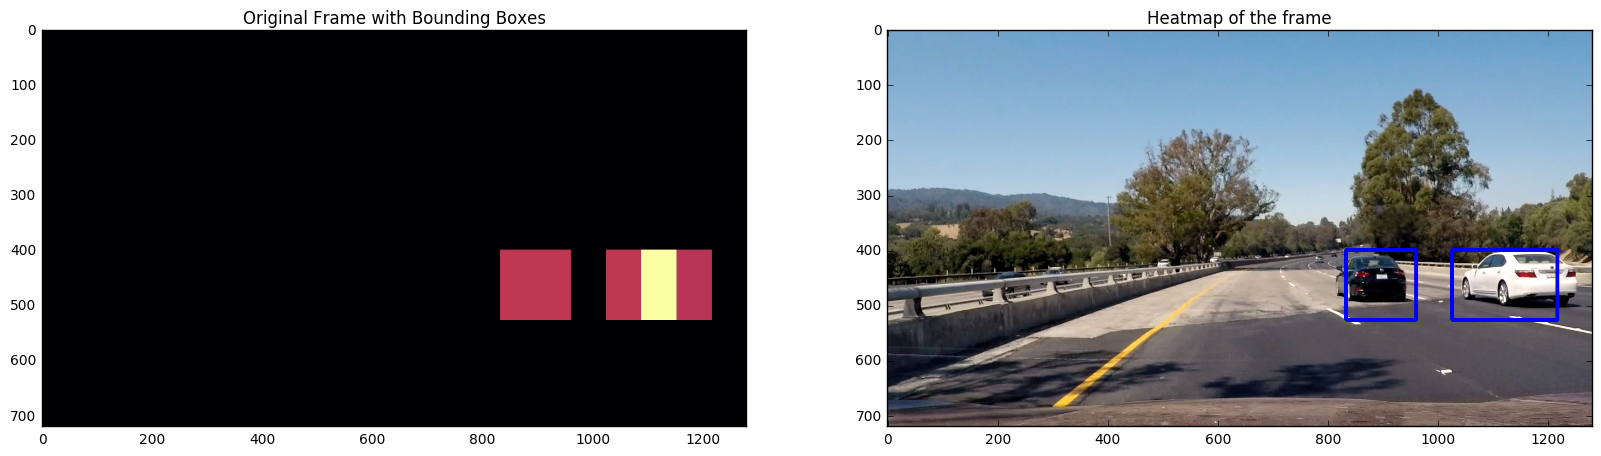

In [16]:
from scipy.ndimage.measurements import label
from p5lib import window

heatmap[heatmap < 0.9] = 0
labels = label(heatmap)
final = window.draw_labeled_bboxes(image, labels)

plot_12({'image': heatmap, 'title': 'Original Frame with Bounding Boxes', 'cmap': 'inferno'},
        {'image': final, 'title': 'Heatmap of the frame'},
        (20, 10))

In the video implementation the temporal feature is used too, with an exponentially weighted average over the last N frames (bests results were between 5 and 7), which helped to disregard lots of false positives.

![Debug Window](writeup_resources/debug_window.jpg "Debug Window")

In this image we can appreciate how the video was debugged to tune some parameters. There are four sections in this diagram:

<table>
<tr><td>Final frame with cars bounded</td><td>Heatmap of the frame</td></tr>
<tr><td>Average of last N heatmaps</td><td>Average of heatmaps thresholded</td></tr>
</table>

We can see how false positives vanished through the different windows until they disappear.

## Video Implementation

The video implementation could be seen here:

[![Vehicle Detection](http://img.youtube.com/vi/5CbVliD1m0E/0.jpg)](https://www.youtube.com/watch?v=5CbVliD1m0E "Vehicle Detection")

## Discussion

This project was fun, really, it's a shame I've just had so little time to work on it. The implementation is far from perfect, but I think it does a decent job.

Things that could have been improved:

* Classifier:
    * Improve the classifier through dimensionality reduction and fine tuning: select the most important features and optimize SVM parameters by random search.
    * Use a dataset generated with the same camera of the video. Changes in lightning, hue and saturation could confuse the classifier (and in fact it happend given that and Extra folder of images taken from the footage was included in the training data, which is kind of overfitting).
    * (To be tested) Use a dataset where partial vehicles are shown: since most of the windows detected partial vehicles this could give an improvement.
    * Rely on prediction (and not confidence) of the classifier to detect vehicles and do a more aggressive thresholding in the pipeline.
* Overall pipeline:
    * Vehicle tracking: keep track of vehicles (with an algorithm like Kalman Filters) and scan the frames over tracked zones to reduce processing speed.
    * Discard small boxes or join a group if they are close.
    * Skip frames to improve real time scanning.
    * Downscale the image (the actual size is 1280x720 which is huge)